In [1]:
import xarray as xr
from calculate_exposure_to_haz import *
import numpy as np
exposures_dict = get_exposures(haz_type='DR')


In [2]:
# defi
from climada.hazard import Hazard
file = INPUT_DIR / "drought/spei03.nc"
spei = xr.open_dataset(file)
spei = spei.rename({'lon': 'longitude', 'lat':'latitude'})


In [3]:
spei_hazard_dict = {}

unique_years = np.arange(2003,2023)

for year in unique_years:
    spei_year = INPUT_DIR / "drought/spei03_year.nc"
    spei_year = spei.sel(time=str(year))
    hazard_for_year = Hazard.from_xarray_raster(spei_year, hazard_type='DR', intensity_unit='spei', intensity='spei')
    hazard_for_year.frequency = np.ones(len(hazard_for_year.frequency))/len(hazard_for_year.frequency)
    hazard_for_year.intensity = - hazard_for_year.intensity # easier to work with positive number for impact calculation
    spei_hazard_dict[year] = hazard_for_year

<GeoAxes: title={'center': 'DR max intensity at each point'}>

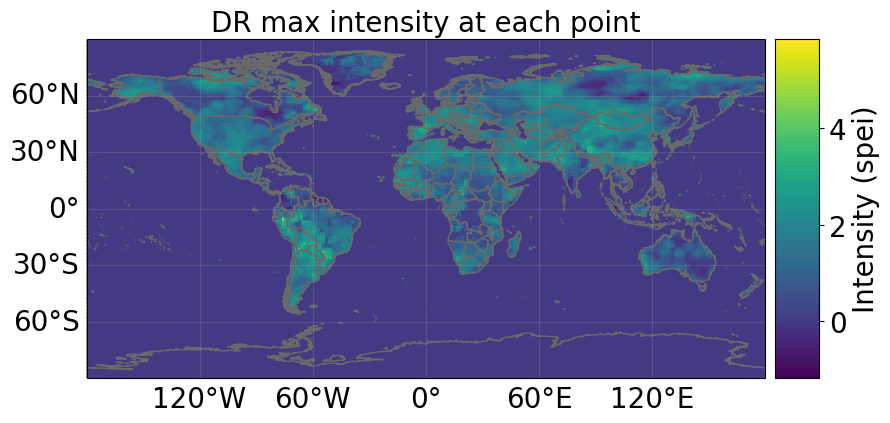

In [4]:
spei_hazard_dict[year].plot_intensity(0)

In [5]:
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

impf_set = ImpactFuncSet()

impf_dr = ImpactFunc()
impf_dr.id = 1
impf_dr.haz_type = 'DR'
impf_dr.name = 'Step function drought'
impf_dr.intensity_unit = ''
impf_dr.intensity = np.array([0, 0.4, 1.99, 2, 5])
impf_dr.mdd = np.array([0, 0, 0, 1, 1])
impf_dr.paa = np.ones(impf_dr.intensity.shape)
impf_dr.check() 
impf_set.append(impf_dr)


<Axes: title={'center': 'DR 1: Step function drought'}, xlabel='Intensity ()', ylabel='Impact (%)'>

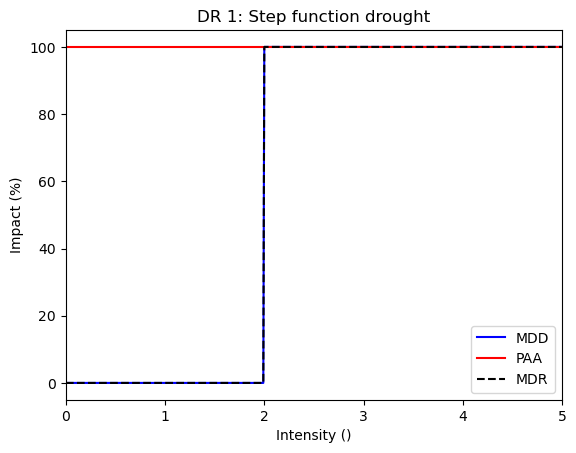

In [6]:
impf_dr.plot()

In [7]:
from climada.engine import Impact, ImpactCalc

# moving exposure
impact_dict = {age:{year:ImpactCalc(exposures_dict[age][str(year)], impf_set, spei_hazard_dict[year]).impact(save_mat=True) for year in spei_hazard_dict} for age in exposures_dict}


In [ ]:
#fixed at 2003 levels
impact_dict_no_change_vuln_pop = {age:{year:ImpactCalc(exposures_dict[age]['2003'], impf_set, spei_hazard_dict[year]).impact(save_mat=True) for year in unique_years} for age in exposures_dict}


In [ ]:
# we need the same "tot_value" attribute to concatenate impacts, we just set it to zero here (some functions might not work, but for our use it is fine

for age in impact_dict_no_change_vuln_pop:
    for year in spei_hazard_dict:
        impact_dict[age][year].tot_value=0
        impact_dict_no_change_vuln_pop[age][year].tot_value=0


In [ ]:
from climada.engine import Impact, ImpactCalc
from util import *
impact_concat = {}
impact_concat_no_change_vuln_pop = {}
for age in impact_dict_no_change_vuln_pop:
    impact_concat[age] = Impact.concat(list(impact_dict[age].values()),reset_event_ids=True)
    impact_concat_no_change_vuln_pop[age] = Impact.concat(list(impact_dict_no_change_vuln_pop[age].values()),reset_event_ids=True)
    write_impact(impact_concat[age], 'DR', age)
    write_impact(impact_concat_no_change_vuln_pop[age], 'DR_ec', age)

